In [7]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from IPython.display import display
pd.options.display.max_columns = 40

# Process h5ad

In [2]:
adata = sc.read_h5ad("qced.h5ad")
adata

AnnData object with n_obs × n_vars = 204374 × 37001
    obs: 'batch', 'aggr_barcode', 'num_features', 'feature_call', 'num_umis', 'maxUmi1', 'maxUmi2', 'cell_barcode', 'guidePvalue', 'pvalueAssign', 'guides', 'multi_output', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'label', 'SingletorDoublet', '<10_percent_mt', '<10000_total_counts', 'qc_pass', '<100000_total_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [3]:
def get_guide_umi_counts(record):
    return pd.Series(dict(zip(record['feature_call'].split('|'), record['num_umis'].split('|')))).astype(int)

adata.obsm['guide_umi_counts'] = adata.obs.apply(get_guide_umi_counts, axis = 1).fillna(0).astype(int)

# Read infercnv results

In [13]:
infercnv_raw = pd.read_pickle("Concat_InferCNV.pkl")
infercnv_raw.dropna(inplace = True)

In [14]:
# remove extra '-1' from barcodes, remove duplicate reference cells 
infercnv_raw.columns = infercnv_raw.columns.str.slice(0,20)
infercnv_raw = infercnv_raw.loc[:,(~pd.Series(infercnv_raw.columns).duplicated().values)]

# Process gene location metadata

In [15]:
gene_locs = pd.read_csv('inferCNVgeneName.txt', sep = '\t', names = ['gene', 'chrom', 'start', 'end'])
gene_to_chrom = gene_locs.set_index('gene')['chrom']

infercnv_raw['chrom'] = infercnv_raw.index.map(gene_to_chrom)
mean_chrom_values_per_cell = infercnv_raw[infercnv_raw['chrom'].str.startswith('chr')].groupby('chrom').mean()\
        .transpose()
adata.obsm['infercnv_chrom_avg'] = mean_chrom_values_per_cell[['chr%d' % (i + 1) for i in range(22)]].reindex(adata.obs.index)

In [16]:
gene_locs.head()

,gene,chrom,start,end
0,MIR1302-2HG,chr1,29554,31109
1,FAM138A,chr1,34554,36081
2,OR4F5,chr1,65419,71585
3,AL627309.1,chr1,89295,133723
4,AL627309.3,chr1,89551,91105


# Guide calling

In [17]:
target_dict = dict(zip(gene_locs.gene, gene_locs.chrom))
target_dict[np.NAN] = np.NAN
target_dict["Non"] = np.NAN
target_dict['Multiple Guides'] = np.NAN

def parse_target(guide):
    
    TARGET_RENAME_MAP = {'CECR1': 'ADA'}
    
    if guide == 'Multiple Guides':
        return np.nan
    else:
        
        target = guide.split('-')[0]
        
        if target in TARGET_RENAME_MAP:
            return TARGET_RENAME_MAP[target]
        else:
            return target
        
def get_guide_chrom(guide):
    return gene_to_chrom.get(parse_target(guide))

In [18]:
adata.obs['target'] = adata.obs['guides'].apply(lambda x: x.split("|")[0].split("-")[0])
adata.obs.loc[adata.obs['guidePvalue'] > 0.05, 'target'] = np.nan
adata.obs['target_chrom'] = adata.obs['target'].apply(lambda x: target_dict[x])

adata.obs['has_infercnv'] = ~pd.isnull(adata.obsm['infercnv_chrom_avg']).any(axis = 1)
adata.obs['lost_chroms'] = (adata.obsm['infercnv_chrom_avg'] <= 0.95).apply(lambda cell_mask: \
        set(cell_mask.index[cell_mask]), axis = 1)
adata.obs.loc[~adata.obs['has_infercnv'], 'lost_chroms'] = np.nan

adata.obs.head()

,batch,aggr_barcode,num_features,feature_call,num_umis,maxUmi1,maxUmi2,cell_barcode,guidePvalue,pvalueAssign,guides,multi_output,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,label,SingletorDoublet,<10_percent_mt,<10000_total_counts,qc_pass,<100000_total_counts,target,target_chrom,has_infercnv,lost_chroms
aggr_barcode,,,,,,,,,,,,,,,,,,,,,,,,,,
AAACCCAAGACATCAA-1-0,0,AAACCCAAGACATCAA-1-0,4.0,HTT-2|PRF1-1|GALC-3|Non-target-8,1|2|1|1,2,1,AAACCCAAGACATCAA-1,0.500000,MultipleGuide,Multiple Guides,Blank,1144,2547.0,5.0,0.196309,NOISE,Multiplet,True,True,False,True,NaN,NaN,True,{chr18}
AAACCCAAGATGACAT-1-0,0,AAACCCAAGATGACAT-1-0,3.0,WFS1-4|PRF1-1|SERPINA1-3,1|1|1,1,1,AAACCCAAGATGACAT-1,0.750000,MultipleGuide,Multiple Guides,CTJD02B,2292,5182.0,874.0,16.866074,NOISE,Singlet,False,True,False,True,NaN,NaN,True,{chr21}
AAACCCAAGCGAGTCA-1-0,0,AAACCCAAGCGAGTCA-1-0,4.0,IFNGR1-3|CD164-3|CD70-3|IL2RB-2,1|1|1|1,1,1,AAACCCAAGCGAGTCA-1,0.750000,MultipleGuide,Multiple Guides,CTJD02E,2248,5076.0,842.0,16.587864,NOISE,Singlet,False,True,False,True,NaN,NaN,True,{}
AAACCCAAGCGCCTCA-1-0,0,AAACCCAAGCGCCTCA-1-0,32.0,CTLA4-3|CCR5-2|RHOH-1|RHOH-4|LRBA-1|CD164-1|IK...,1|2|1|1|1|1|1|1|3|1|1|1|1|1|1|1|1|1|1|1|2|8|1|...,12,8,AAACCCAAGCGCCTCA-1,0.251722,MultipleGuide,Multiple Guides,CTJD02F,6458,28314.0,1122.0,3.962704,NOISE,Singlet,True,False,True,True,NaN,NaN,True,{chr19}
AAACCCAAGTAGCATA-1-0,0,AAACCCAAGTAGCATA-1-0,14.0,IFNGR1-4|TRBC1-4|CD5-1|LAG3-2|TNFRSF1A-3|SERPI...,1|6|1|1|1|2|1|1|1|1|1|1|1|1,6,2,AAACCCAAGTAGCATA-1,0.144531,MultipleGuide,Multiple Guides,CTJD02C,5033,21731.0,972.0,4.472873,NOISE,Singlet,True,False,True,True,NaN,NaN,True,{}


# DOWNSAMPLING
Random sample of genes is taken of given size. Representative example is shown in paper supplement. 

In [28]:
n = 4000
infercnv_raw = infercnv_raw.loc[np.random.choice(infercnv_raw.index, n, replace=False),:]

# Breakpoint calling

In [29]:
for chrom in sorted(list(set(infercnv_raw['chrom']))):
    print(chrom)
    if chrom[0] != "c":
        continue
        
    #if chrom != "chr12":
    #    continue
        
    locs = pd.Series(infercnv_raw.loc[infercnv_raw['chrom'] == chrom,:].index)
    locs = locs.apply(lambda x: gene_locs.loc[gene_locs['gene'] == x, "start"].values[0])
    order = np.argsort(locs)
    vals = infercnv_raw.loc[infercnv_raw['chrom'] == chrom, adata[adata.obs['has_infercnv']].obs.index]
    locs = locs[order].to_numpy()
    vals = vals.iloc[order,:].to_numpy()
    vals_binary = (vals > 0.95).astype(int)
    
    left_binary = np.cumsum(vals_binary, axis = 0)[:-1]
    left_binary_den = (np.array(list(range(vals_binary.shape[0] - 1))) + 1)[:,None]
    left_binary = left_binary/left_binary_den
    right_binary = np.cumsum(vals_binary[::-1], axis = 0)[:-1][::-1]
    right_binary_den = (np.array(list(range(vals_binary.shape[0] - 1))) + 1)[:,None][::-1]
    right_binary = right_binary/right_binary_den
    breakpoints = np.argmax(np.abs(left_binary - right_binary), axis = 0)
    
    left_binary_avg = left_binary[breakpoints, range(len(breakpoints))]
    right_binary_avg = right_binary[breakpoints, range(len(breakpoints))]
    
    left = np.cumsum(vals, axis = 0)[:-1]
    left_den = (np.array(list(range(vals.shape[0] - 1))) + 1)[:,None]
    left = left/left_den
    right = np.cumsum(vals[::-1], axis = 0)[:-1][::-1]
    right_den = (np.array(list(range(vals.shape[0] - 1))) + 1)[:,None][::-1]
    right = right/right_den
    
    left_avg = left[breakpoints, range(len(breakpoints))]
    right_avg = right[breakpoints, range(len(breakpoints))]
    
    locs = np.tile(locs, (len(breakpoints), 1))
    locs1 = locs[range(len(breakpoints)), breakpoints]
    locs2 = locs[range(len(breakpoints)), breakpoints + 1]
    
    breakpoint_locs = np.mean(np.vstack([locs1, locs2]), axis = 0)
    
    #print(len(locs))
    #print(vals_binary.shape)
    
    adata.obs.loc[adata.obs['has_infercnv'], chrom + "_bp_loc"] = breakpoint_locs
    adata.obs.loc[adata.obs['has_infercnv'], chrom + "_bp_n"] = breakpoints
    adata.obs.loc[adata.obs['has_infercnv'], chrom + "_left"] = left_avg
    adata.obs.loc[adata.obs['has_infercnv'], chrom + "_right"] = right_avg
    adata.obs.loc[adata.obs['has_infercnv'], chrom + "_left_binary"] = left_binary_avg
    adata.obs.loc[adata.obs['has_infercnv'], chrom + "_right_binary"] = right_binary_avg
    adata.obs.loc[adata.obs['has_infercnv'], chrom + "_left_n"] = breakpoints + 1
    adata.obs.loc[adata.obs['has_infercnv'], chrom + "_right_n"] = vals.shape[0] - (breakpoints + 1)
    adata.obs.loc[adata.obs['has_infercnv'], chrom + "_binary"] = np.mean(vals_binary, axis = 0)

GL000219.1
chr1
chr10
chr11
chr12
chr13
chr14
chr15
chr16
chr17
chr18
chr19
chr2
chr20
chr21
chr22
chr3
chr4
chr5
chr6
chr7
chr8
chr9


In [30]:
cols = adata.obs.columns[adata.obs.columns.str.contains("bp") | adata.obs.columns.str.contains("right") |
                 adata.obs.columns.str.contains("left") | adata.obs.columns.str.contains("binary") |
                 adata.obs.columns.str.contains("event")       ]
adata.obs.loc[:,cols].to_csv("aneuploidy_events.csv")
adata.obs.head()

,batch,aggr_barcode,num_features,feature_call,num_umis,maxUmi1,maxUmi2,cell_barcode,guidePvalue,pvalueAssign,guides,multi_output,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,label,SingletorDoublet,<10_percent_mt,<10000_total_counts,...,chr7_right_n,chr7_binary,chr8_bp_loc,chr8_bp_n,chr8_left,chr8_right,chr8_left_binary,chr8_right_binary,chr8_left_n,chr8_right_n,chr8_binary,chr9_bp_loc,chr9_bp_n,chr9_left,chr9_right,chr9_left_binary,chr9_right_binary,chr9_left_n,chr9_right_n,chr9_binary
aggr_barcode,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AAACCCAAGACATCAA-1-0,0,AAACCCAAGACATCAA-1-0,4.0,HTT-2|PRF1-1|GALC-3|Non-target-8,1|2|1|1,2,1,AAACCCAAGACATCAA-1,0.500000,MultipleGuide,Multiple Guides,Blank,1144,2547.0,5.0,0.196309,NOISE,Multiplet,True,True,...,4.0,0.857868,38629256.0,39.0,1.001149,0.963400,1.0,0.656566,40.0,99.0,0.755396,342572.5,0.0,1.001149,1.001149,1.0,1.000000,1.0,153.0,1.000000
AAACCCAAGATGACAT-1-0,0,AAACCCAAGATGACAT-1-0,3.0,WFS1-4|PRF1-1|SERPINA1-3,1|1|1,1,1,AAACCCAAGATGACAT-1,0.750000,MultipleGuide,Multiple Guides,CTJD02B,2292,5182.0,874.0,16.866074,NOISE,Singlet,False,True,...,178.0,0.903553,123269928.5,107.0,1.019951,0.933423,1.0,0.225806,108.0,31.0,0.827338,342572.5,0.0,1.082782,1.002113,1.0,1.000000,1.0,153.0,1.000000
AAACCCAAGCGAGTCA-1-0,0,AAACCCAAGCGAGTCA-1-0,4.0,IFNGR1-3|CD164-3|CD70-3|IL2RB-2,1|1|1|1,1,1,AAACCCAAGCGAGTCA-1,0.750000,MultipleGuide,Multiple Guides,CTJD02E,2248,5076.0,842.0,16.587864,NOISE,Singlet,False,True,...,196.0,1.000000,86405402.0,74.0,1.042024,0.927051,1.0,0.281250,75.0,64.0,0.669065,115722400.0,92.0,1.052622,0.959163,1.0,0.590164,93.0,61.0,0.837662
AAACCCAAGCGCCTCA-1-0,0,AAACCCAAGCGCCTCA-1-0,32.0,CTLA4-3|CCR5-2|RHOH-1|RHOH-4|LRBA-1|CD164-1|IK...,1|2|1|1|1|1|1|1|3|1|1|1|1|1|1|1|1|1|1|1|2|8|1|...,12,8,AAACCCAAGCGCCTCA-1,0.251722,MultipleGuide,Multiple Guides,CTJD02F,6458,28314.0,1122.0,3.962704,NOISE,Singlet,True,False,...,85.0,0.766497,7362166.0,0.0,1.001149,1.001149,1.0,1.000000,1.0,138.0,1.000000,342572.5,0.0,1.001149,1.001149,1.0,1.000000,1.0,153.0,1.000000
AAACCCAAGTAGCATA-1-0,0,AAACCCAAGTAGCATA-1-0,14.0,IFNGR1-4|TRBC1-4|CD5-1|LAG3-2|TNFRSF1A-3|SERPI...,1|6|1|1|1|2|1|1|1|1|1|1|1|1,6,2,AAACCCAAGTAGCATA-1,0.144531,MultipleGuide,Multiple Guides,CTJD02C,5033,21731.0,972.0,4.472873,NOISE,Singlet,True,False,...,196.0,1.000000,7362166.0,0.0,1.001149,1.001149,1.0,1.000000,1.0,138.0,1.000000,137430670.0,152.0,1.001149,0.930366,1.0,0.000000,153.0,1.0,0.993506


# Updated definitions

In [31]:
aneuploidy_events = pd.read_csv("aneuploidy_events.csv", index_col = 0)

In [32]:
LOSS_FRAC = 0.7
MIN_GENES = 150

for chrom in ('chr%d' % i for i in range(1, 23)):
    
    left_binary = aneuploidy_events['%s_left_binary' % chrom]
    left_n = aneuploidy_events['%s_left_n' % chrom]
    right_binary = aneuploidy_events['%s_right_binary' % chrom]
    right_n = aneuploidy_events['%s_right_n' % chrom]
    total_binary = (left_n * left_binary + right_n * right_binary) / (left_n + right_n)
    
    lost_all = (total_binary <= 1 - LOSS_FRAC)
    lost_left = (left_binary <= 1 - LOSS_FRAC)
    lost_right = (right_binary <= 1 - LOSS_FRAC)
    lost_only_left = lost_left & (~lost_right)
    lost_only_right = lost_right & (~lost_left)
    enough_genes_left = (left_n >= MIN_GENES)
    enough_genes_right = (right_n >= MIN_GENES)
    lost_partial = (lost_only_left & enough_genes_left) | (lost_only_right & enough_genes_right)
    
    event = np.where(lost_partial, 'lost_partial', np.where(lost_all, 'lost_all', 'no_loss'))
    aneuploidy_events['%s_event' % chrom] = event

In [33]:
for chrom in ('chr%d' % i for i in range(1, 23)):
    print('%s: %s' % (chrom, aneuploidy_events['%s_event' % chrom].value_counts().to_dict()))

chr1: {'no_loss': 203194, 'lost_partial': 1130, 'lost_all': 50}
chr2: {'no_loss': 203992, 'lost_partial': 295, 'lost_all': 87}
chr3: {'no_loss': 204119, 'lost_partial': 128, 'lost_all': 127}
chr4: {'no_loss': 203867, 'lost_all': 459, 'lost_partial': 48}
chr5: {'no_loss': 203670, 'lost_partial': 430, 'lost_all': 274}
chr6: {'no_loss': 203925, 'lost_partial': 352, 'lost_all': 97}
chr7: {'no_loss': 204032, 'lost_partial': 201, 'lost_all': 141}
chr8: {'no_loss': 204080, 'lost_all': 294}
chr9: {'no_loss': 203896, 'lost_all': 472, 'lost_partial': 6}
chr10: {'no_loss': 203751, 'lost_all': 468, 'lost_partial': 155}
chr11: {'no_loss': 203090, 'lost_partial': 1209, 'lost_all': 75}
chr12: {'no_loss': 204017, 'lost_partial': 281, 'lost_all': 76}
chr13: {'no_loss': 200944, 'lost_all': 3430}
chr14: {'no_loss': 203497, 'lost_all': 877}
chr15: {'no_loss': 204033, 'lost_all': 341}
chr16: {'no_loss': 204142, 'lost_all': 171, 'lost_partial': 61}
chr17: {'no_loss': 204111, 'lost_partial': 150, 'lost_all':

# Plotting

Total cells: 108458
31591 cells are targeted, 13112 have a loss event
Total enrichment: 4.254 (across 2594 cells)


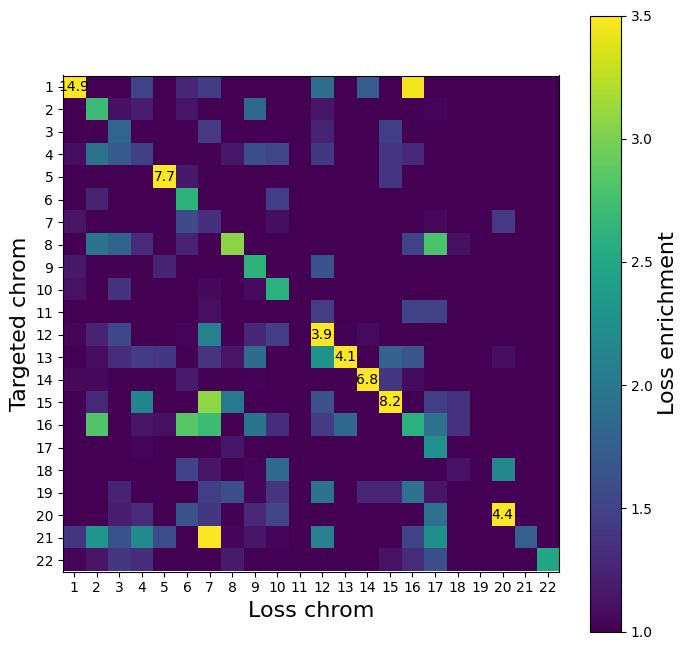

In [34]:
ASSIGN_GUIDE_BY_DOMINANCE = True
GUIDE_PVAL_CUTOFF = 0.05
GUIDE_MIN_UMIS = 3
LOSS_EVENT_LABELS = {'lost_all', 'lost_partial'}
CELL_QC_MASK = adata.obs['qc_pass']
VMIN, VMAX = 1.0, 3.5

CHROMS = ['chr%d' % i for i in range(1, 23)]

if ASSIGN_GUIDE_BY_DOMINANCE:
    cell_guides = pd.Series(np.where(adata.obs['guidePvalue'] < GUIDE_PVAL_CUTOFF, adata.obs['guides']\
            .apply(lambda raw_guides: raw_guides.split('|')[0]).astype(str).apply(lambda value: {value}), set()), \
            index = adata.obs.index)
else:
    cell_guides = (adata.obsm['guide_umi_counts'] >= GUIDE_MIN_UMIS).apply(lambda cell_mask: \
            set(cell_mask.index[cell_mask]), axis = 1)
    
cell_targeted_chroms = cell_guides.apply(lambda guides: {chrom for chrom in map(get_guide_chrom, guides) if chrom \
        is not None})

target_mask_per_chrom = pd.DataFrame({chrom: cell_targeted_chroms.apply(lambda cell_chroms: chrom in cell_chroms) for \
        chrom in CHROMS})
loss_mask_per_chrom = pd.DataFrame({chrom: aneuploidy_events['%s_event' % chrom].isin(LOSS_EVENT_LABELS) for \
        chrom in CHROMS})

cell_mask = CELL_QC_MASK
target_mask_per_chrom = target_mask_per_chrom[cell_mask]
loss_mask_per_chrom = loss_mask_per_chrom[cell_mask]
print('Total cells: %d' % cell_mask.sum())
print('%d cells are targeted, %s have a loss event' % (target_mask_per_chrom.any(axis = 1).sum(), \
        loss_mask_per_chrom.any(axis = 1).sum()))

enrch_per_cell = (target_mask_per_chrom & loss_mask_per_chrom).mean(axis = 1) / \
        (target_mask_per_chrom.mean(axis = 1) * loss_mask_per_chrom.mean(axis = 1))
total_enrch = enrch_per_cell.mean()
print('Total enrichment: %.3f (across %d cells)' % (total_enrch, pd.notnull(enrch_per_cell).sum()))

loss_per_target = pd.DataFrame(np.nan, index = CHROMS, columns = CHROMS)
loss_enrch_per_target = pd.DataFrame(np.nan, index = CHROMS, columns = CHROMS)

for target_chrom in CHROMS:
    
    chrom_target_mask = target_mask_per_chrom[target_chrom]
    
    for loss_chrom in CHROMS:
        chrom_loss_mask = loss_mask_per_chrom[loss_chrom]
        loss_per_target.loc[target_chrom, loss_chrom] = chrom_loss_mask[chrom_target_mask].mean()
        loss_enrch_per_target.loc[target_chrom, loss_chrom] = (chrom_target_mask & chrom_loss_mask).mean() / \
                (chrom_target_mask.mean() * chrom_loss_mask.mean())
        
fig, ax = plt.subplots(figsize = (8, 8))
heatmap = ax.imshow(loss_enrch_per_target, vmin = VMIN, vmax = VMAX)
ax.set_xticks(np.arange(len(CHROMS)))
ax.set_xticklabels(np.arange(len(CHROMS)) + 1)
ax.set_xlabel('Loss chrom', fontsize = 16)
ax.set_yticks(np.arange(len(CHROMS)))
ax.set_yticklabels(np.arange(len(CHROMS)) + 1)
ax.set_ylabel('Targeted chrom', fontsize = 16)
colorbar = fig.colorbar(heatmap)
colorbar.set_label('Loss enrichment', fontsize = 16)

for i in range(len(CHROMS)):
    for j in range(len(CHROMS)):
        if loss_enrch_per_target.iloc[i, j] > VMAX:
            ax.text(i, j, '%.1f' % loss_enrch_per_target.iloc[i, j], ha = 'center', va = 'center')